In [4]:
%config IPCompleter.greedy=True

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

In [6]:
ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/movies.csv')
tags_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/tags.csv')
links_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/links.csv')

In [7]:
#ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/ratings.csv')
#movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/movies.csv')

# Dataset

In [8]:
#percentage = 5
#movies_df = movies_df.head(int(len(movies_df)*(percentage/100)))
#ratings_df = ratings_df.head(int(len(ratings_df)*(percentage/100)))

In [9]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [10]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [11]:
#ratings_df.columns = ['userId', 'movieId', 'rating', 'timestamp']

In [12]:
num_users = ratings_df['userId'].unique()
print(len(num_users))
num_items = ratings_df['movieId'].unique()
print(len(num_items))

610
9724


# Spotlight

## Data preperation for Spotlight

The ids are not consecutive. For examples the id of a movies is shown multiple times. For this reason the procedure below is implemented. The reversed map is still saved to be used when needed.

In [13]:
from collections import defaultdict
from itertools import count
uid_map = defaultdict(count().__next__)
iid_map = defaultdict(count().__next__)
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %d got uid %d" % (1, uid_map[3]))
print("movieId %d got iid %d" % (54001, iid_map[54001]))

userId 1 got uid 2
movieId 54001 got iid 2518


Create the dataset variable representing the dataset prepared for use to create a recommendation systems using the Spotlight platform.

## Implicit Factorization model

In [14]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  


#pecify the ids of the users and items for all the pairs of user-item interactions
implicit_interaction = Interactions(user_ids=uids,
                                   item_ids=iids,
                                   timestamps = timestamps)


#lets initialise the seed, so that its repeatable and reproducible 
implicit_train_tmp, implicit_test = random_train_test_split(implicit_interaction, random_state=np.random.seed(42))
implicit_train, implicit_val = random_train_test_split(implicit_train_tmp, random_state=np.random.seed(42))
implicit_train_features, implicit_train_labels = random_train_test_split(implicit_train, random_state=np.random.seed(42))

In [15]:
print(implicit_train)
print(implicit_test)
print(implicit_val)
print(implicit_train_features)
print(implicit_train_labels)

<Interactions dataset (610 users x 9724 items x 64534 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>
<Interactions dataset (610 users x 9724 items x 16134 interactions)>
<Interactions dataset (610 users x 9724 items x 51627 interactions)>
<Interactions dataset (610 users x 9724 items x 12907 interactions)>


### Train-test split to DataFrame

Train and test interaction datasets are converted to dataframes, in order to be used from other models too and provide consistent and fair results.

In [16]:
def interactionToDataFrame(dataset):
    converted_users = []
    converted_movies = []
    rating = []
    #FOR EACH INTERACTION
    for i in range(len(dataset.user_ids)):
        converted_users.append(uid_rev_map[dataset.user_ids[i]])
        converted_movies.append(iid_rev_map[dataset.item_ids[i]])
        rating.append(float(ratings_df['rating'][(ratings_df['movieId'] == converted_movies[i]) & (
            ratings_df['userId'] == converted_users[i])].values))

    df = pd.DataFrame({'user_id': converted_users,
                       'movie_id': converted_movies, 'rating': rating})
    return df

In [17]:
train_df = interactionToDataFrame(implicit_train)
val_df = interactionToDataFrame(implicit_val)
test_df = interactionToDataFrame(implicit_test)
train_features_df = interactionToDataFrame(implicit_train_features)
train_labels_df = interactionToDataFrame(implicit_train_labels)

### Pickle 

Save

In [18]:
'''train_df.to_pickle("./train_df.pkl")
test_df.to_pickle("./test_df.pkl")
val_df.to_pickle("./val_df.pkl")'''

'train_df.to_pickle("./train_df.pkl")\ntest_df.to_pickle("./test_df.pkl")\nval_df.to_pickle("./val_df.pkl")'

Load

In [19]:
'''train_df = pd.read_pickle("./train_df.pkl")
test_df = pd.read_pickle("./test_df.pkl")
val_df = pd.read_pickle("./val_df.pkl")'''

'train_df = pd.read_pickle("./train_df.pkl")\ntest_df = pd.read_pickle("./test_df.pkl")\nval_df = pd.read_pickle("./val_df.pkl")'

### Train Implicit Factorization model 

In [20]:
implicit_model = ImplicitFactorizationModel(n_iter=5)

current = time.time()

implicit_model.fit(implicit_train, verbose=True)

end = time.time()
diff = end - current
print('Training took %d second' % (diff))

Epoch 0: loss 0.7519587885014153
Epoch 1: loss 0.4427929866926472
Epoch 2: loss 0.3996278969902295
Epoch 3: loss 0.3678008865697582
Epoch 4: loss 0.33610570171604987
Training took 57 second


Distribution of scores for a user

(array([2.000e+00, 3.500e+01, 1.170e+02, 3.760e+02, 7.530e+02, 1.211e+03,
        1.304e+03, 1.135e+03, 6.840e+02, 4.810e+02, 3.450e+02, 3.300e+02,
        2.640e+02, 2.040e+02, 1.870e+02, 1.550e+02, 1.410e+02, 1.300e+02,
        1.160e+02, 1.130e+02, 1.280e+02, 1.270e+02, 1.120e+02, 9.600e+01,
        9.500e+01, 1.000e+02, 1.100e+02, 1.060e+02, 1.080e+02, 1.330e+02,
        1.130e+02, 1.160e+02, 1.050e+02, 7.300e+01, 4.300e+01, 3.000e+01,
        2.300e+01, 1.300e+01, 9.000e+00, 1.000e+00]),
 array([-12.0687685 , -11.454397  , -10.840025  , -10.225654  ,
         -9.611282  ,  -8.996911  ,  -8.382539  ,  -7.7681675 ,
         -7.153796  ,  -6.5394244 ,  -5.9250526 ,  -5.3106813 ,
         -4.6963096 ,  -4.0819383 ,  -3.4675667 ,  -2.8531952 ,
         -2.2388234 ,  -1.624452  ,  -1.0100803 ,  -0.39570883,
          0.21866274,   0.8330343 ,   1.4474058 ,   2.0617774 ,
          2.676149  ,   3.2905207 ,   3.9048922 ,   4.5192637 ,
          5.133635  ,   5.748007  ,   6.362378  ,   6.

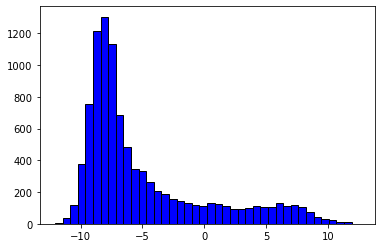

In [21]:
plt.hist(implicit_model.predict(0), color = 'blue', edgecolor = 'black',
         bins = 40)

Not a lot items with high score

### Top-K predictions for a user

The function below (allUsers_topK_implicit) returns a list that contains the top-K recommendations for each user.

In [22]:
import scipy.stats as st
k = 100
def topK_implicit(user, model, k=100):
  a= list()
  ranks = st.rankdata(-model.predict(user))   
  for iid in np.argwhere(ranks <= k):
    #print(iid_rev_map[iid.item(0)])
    a.append(iid_rev_map[iid.item(0)])
  return a

rec_forUser = topK_implicit(0,implicit_model)
print(rec_forUser)

[1, 47, 50, 110, 163, 223, 231, 260, 296, 316, 349, 356, 367, 457, 480, 500, 527, 590, 592, 593, 608, 648, 733, 780, 1073, 1089, 1196, 1198, 1208, 1210, 1270, 1625, 2571, 2858, 3052, 3386, 318, 2288, 32, 539, 588, 1259, 34, 150, 153, 253, 344, 380, 474, 589, 597, 2, 10, 25, 95, 141, 160, 161, 165, 185, 208, 252, 288, 292, 293, 317, 329, 337, 339, 353, 370, 377, 432, 434, 435, 454, 485, 520, 628, 783, 1101, 586, 784, 1653, 111, 2490, 1036, 1221, 1375, 442, 555, 1356, 3751, 107, 173, 420, 1376, 1035, 786, 1320]


In [23]:
def allUsers_topK_implicit(model):
    a = []
    for i in range(len(num_users)):
       a.append(topK_implicit(i,model))
    return a

In [24]:
movies_df.loc[movies_df['movieId'].isin(rec_forUser)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
9,10,GoldenEye (1995),Action|Adventure|Thriller
24,25,Leaving Las Vegas (1995),Drama|Romance
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
...,...,...,...
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2145,2858,American Beauty (1999),Drama|Romance
2302,3052,Dogma (1999),Adventure|Comedy|Fantasy
2526,3386,JFK (1991),Drama|Mystery|Thriller


In [25]:
movies_pred = movies_df['movieId'][movies_df['movieId'].isin(rec_forUser)]

### Μovies watched from a user

In [26]:
actual = ratings_df[ratings_df["userId"]==uid_rev_map.get(0)].groupby("movieId")["movieId"].count().sort_values(ascending=False).head(100)

In [27]:
actual = actual.index.tolist()

In [28]:
movies_df.loc[movies_df['movieId'].isin(actual)]

,movieId,title,genres
2,3,Grumpier Old Men (1995),Comedy|Romance
5,6,Heat (1995),Action|Crime|Thriller
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
62,70,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
...,...,...,...
1332,1804,"Newton Boys, The (1998)",Crime|Drama
1333,1805,Wild Things (1998),Crime|Drama|Mystery|Thriller
1401,1920,Small Soldiers (1998),Animation|Children|Fantasy|War
2991,4006,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi


In [29]:
movies_watched = movies_df['movieId'][movies_df['movieId'].isin(actual)]

### NDCG Score

In [30]:
allUsers_topK_imp = allUsers_topK_implicit(implicit_model)

In [31]:
rec_forUser == allUsers_topK_imp[0]

True

In [32]:
relevance_implicit = []
for i in range(len(rec_forUser)):
    if rec_forUser[i] in test_df['movie_id'][test_df['user_id'] == 1].values.tolist():
        relevance_implicit.append(1)
    else:
        relevance_implicit.append(0)
    

Compute the relevance for each user. The relevance containes 0s and 1s based on which movies each has watched. For every recommended movie that the user has actually watched, the value of 1 is assigned. There is a relevance list for each user.

In [33]:
def relevance_spotlight_implicit(allUsers_topK):
    relevance_implicit_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(allUsers_topK[count])):
            if allUsers_topK[count][j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_implicit_full.append(helper)
        helper = []
        count += 1
    return relevance_implicit_full

In [34]:
relevance_implicit_full = relevance_spotlight_implicit(allUsers_topK_imp)

In [35]:
relevance_implicit == relevance_implicit_full[0]

True

The dcg and ideal_dcg functions are taken form https://github.com/lezzago/LambdaMart/blob/master/lambdamart.py. They are necessary to compute the desired NDCG evaluation metric.

In [36]:
def dcg(scores):
    """
    Returns the DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    DCG_val: int
        This is the value of the DCG on the given scores
    """
    return np.sum([
                    (np.power(2, scores[i]) - 1) / np.log2(i + 2)
                    for i in range(len(scores))
                ])

In [37]:
def ideal_dcg(scores):
    """
    Returns the Ideal DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    Ideal_DCG_val: int
        This is the value of the Ideal DCG on the given scores
    """
    scores = [score for score in sorted(scores)[::-1]]
    return dcg(scores)

In [38]:
def NDCG_forUser(relevance):
    return dcg(relevance) / ideal_dcg(relevance)

In [39]:
ndcg = NDCG_forUser(relevance_implicit_full[0])
print(ndcg)
ndcg = NDCG_forUser(relevance_implicit)
print(ndcg)

0.5221047934484787
0.5221047934484787


Creation of a list (allUsers_implicit_ndcg) that contains the NDCG score for each user.

In [40]:
def allUsers_ndcg(relevance):
    allUsers_implicit_ndcg = []
    for i in range(len(num_users)):
        allUsers_implicit_ndcg.append(NDCG_forUser(relevance[i]))
    return allUsers_implicit_ndcg

In [41]:
allUsers_implicit_ndcg = allUsers_ndcg(relevance_implicit_full)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Fill the nan values with 0s.

In [42]:
allUsers_implicit_ndcg = pd.Series(allUsers_implicit_ndcg).fillna(0).tolist()

In [43]:
np.array(allUsers_implicit_ndcg).mean()

0.3239658263329035

### MRR Score

In [44]:
#Calculate reciprocal rank. Where is the first relevant item?
def RR_forUsers(relevance):
    count = 0
    reciprocal_rank_perUser = []
    #for each user
    for rel in relevance:
        #for each item in a relevance list
        for r in rel:
            count += 1
            if r == 1:
                #1/position
                first_perUser = 1/count
                #stop the iteration. Only care about the first relevant item
                break
        reciprocal_rank_perUser.append(first_perUser)
        count = 0
    return reciprocal_rank_perUser

In [45]:
rr_implicit = RR_forUsers(relevance_implicit_full)

In [46]:
def calculate_mrr(rr):    
    #or np.array(rr).mean()
    return np.array(rr).sum()/len(rr)

In [47]:
implicit_mrr = calculate_mrr(rr_implicit)

In [48]:
implicit_mrr

0.1977996545202408

### MAP Score

In [49]:
#calculate average precision.
def calculate_averagePrecision(relevance):
    count_positive = 0
    positives = []
    ap_perUser = []
    count = 0
    #for each user
    for rel in relevance:
        #for each item in a relevance list
        for r in rel:
            count += 1
            if r == 1:
                count_positive += 1
                #First, second, etc. relevant item/ position
                positives.append(count_positive/count)
        #mean of relevant item/position
        ap_perUser.append(np.array(positives).sum()/count_positive)
        count_positive = 0
        positives = []
        count = 0
    return ap_perUser

In [50]:
implicit_ap = calculate_averagePrecision(relevance_implicit_full)
implicit_ap = pd.Series(implicit_ap).fillna(0).tolist()

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [51]:
def calculate_MAP(ap):
    #or np.array(ap).mean()
    return np.array(ap).sum()/len(ap)

In [52]:
implicit_map = calculate_MAP(implicit_ap)
implicit_map

0.09876741866048241

# SVD

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [53]:
df_movie_features = train_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [54]:
df_movie_features

movie_id,1,2,3,4,5,6,7,8,9,10,...,190209,190213,190221,193565,193567,193571,193579,193581,193583,193587
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVD implementation

In [55]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(df_movie_features, k = 10)

## Predictions

To get the prediction of a rating of an item dj, we can calculate the dot product of the two vectors.
The sigma variable has just the values, so I have to convert to a diagonal matrix in orded to implement the matrix multiplication.

In [56]:
sigma = np.diag(sigma)
svd_predictions_score = np.dot(np.dot(U, sigma), Vt)
svd_predictions_score_df = pd.DataFrame(svd_predictions_score, columns = df_movie_features.columns)


In [57]:
svd_predictions_score[1]

array([ 0.13372434,  0.09079515, -0.07045479, ...,  0.00506549,
        0.0044323 ,  0.0044323 ])

In [58]:
svd_predictions_score_df

movie_id,1,2,3,4,5,6,7,8,9,10,...,190209,190213,190221,193565,193567,193571,193579,193581,193583,193587
0,1.923310,0.499768,0.664960,-0.005204,0.085264,1.146848,-0.002223,0.053179,0.068889,1.636955,...,0.000037,0.000009,0.000009,-0.010956,-0.009391,-0.012522,-0.010956,-0.012522,-0.010956,-0.010956
1,0.133724,0.090795,-0.070455,0.002798,0.027160,0.046979,0.013243,-0.019596,-0.002608,-0.056177,...,0.001613,0.000403,0.000403,0.004432,0.003799,0.005065,0.004432,0.005065,0.004432,0.004432
2,0.017810,0.001554,0.012323,-0.001358,-0.003890,0.019478,-0.003033,0.000462,0.000621,0.035801,...,-0.000207,-0.000052,-0.000052,-0.000060,-0.000051,-0.000069,-0.000060,-0.000069,-0.000060,-0.000060
3,0.827315,0.102587,0.250474,0.012745,0.116908,0.391501,0.126127,-0.004969,-0.006726,0.351184,...,0.001490,0.000372,0.000372,-0.005390,-0.004620,-0.006161,-0.005390,-0.006161,-0.005390,-0.005390
4,0.904273,0.506492,0.346607,0.105665,0.382287,0.715478,0.474145,0.058617,0.062012,0.754547,...,0.003023,0.000756,0.000756,-0.000340,-0.000292,-0.000389,-0.000340,-0.000389,-0.000340,-0.000340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,-1.025654,0.739079,-0.233676,0.247012,0.366234,2.423017,2.399554,-0.057102,-0.150454,-0.287115,...,0.008529,0.002132,0.002132,0.008121,0.006961,0.009281,0.008121,0.009281,0.008121,0.008121
606,1.641467,0.577603,0.604178,0.075468,0.321918,1.081056,0.347699,0.073348,0.079045,1.368803,...,0.002005,0.000501,0.000501,-0.005892,-0.005051,-0.006734,-0.005892,-0.006734,-0.005892,-0.005892
607,2.589121,1.231934,1.486104,-0.001623,0.319114,1.646995,0.286805,0.363429,0.081883,2.878740,...,-0.004938,-0.001234,-0.001234,-0.035917,-0.030786,-0.041048,-0.035917,-0.041048,-0.035917,-0.035917
608,0.521540,0.314778,0.213771,0.065907,0.243540,0.416261,0.289529,0.040885,0.038727,0.489582,...,0.001142,0.000286,0.000286,0.000446,0.000383,0.000510,0.000446,0.000510,0.000446,0.000446


In [59]:
svd_predictions_score_df[svd_predictions_score_df.index == 609]

movie_id,1,2,3,4,5,6,7,8,9,10,...,190209,190213,190221,193565,193567,193571,193579,193581,193583,193587
609,3.962944,-0.174674,0.172116,0.139073,0.494955,1.765759,-0.099499,0.713748,0.018473,0.768151,...,0.012415,0.003104,0.003104,0.045229,0.038768,0.05169,0.045229,0.05169,0.045229,0.045229


## Top-K recommendations

The function below returns a list that contains the top-100 recommendations for each user

In [60]:
svd_predictions_score_df[svd_predictions_score_df.index == 0].values[0]

array([ 1.92331   ,  0.49976777,  0.6649602 , ..., -0.01252153,
       -0.01095634, -0.01095634])

In [61]:
def SVD_topK_first(score_df):
    topK_svd_rec = []
    for i in range(len(num_users)):
        svd_h_df = pd.DataFrame({'movie_id': score_df[score_df.index == i].columns,
                                 'score': score_df[score_df.index == i].values[0]})
        svd_h_df = svd_h_df.sort_values('score', ascending=False)
        svd_h_df = svd_h_df.head(100)
        topK_svd_rec.append(svd_h_df['movie_id'].values)
    return topK_svd_rec

In [62]:
a = SVD_topK_first(svd_predictions_score_df)

In [63]:
a[0]

array([1196,  260, 1210,  589,  608, 2571, 1198, 2028, 1214,  541, 1136,
       1291, 1200,    1, 2858,  110,  593,  296,  480,  780, 1197, 1240,
       2762, 1617, 1036,  924, 1527, 1265, 2916, 1270, 1610, 1221, 2987,
        457, 2115,   10, 1387,  356, 1073, 1391, 2716,  858,  592,  318,
       2997, 1356, 1206, 1213, 2791, 3793, 1258,   32, 1097, 2918, 1653,
       1208,  648, 1222, 2628, 2000, 2985, 3578, 2700, 1517, 1079, 1127,
       4226, 1259,  377, 1732, 2683,  778, 1580, 1968,  223, 2640, 4993,
       1682,  316, 2959, 1784,  733, 2355,   47,    6, 2174, 1500, 1215,
         50, 1374,  150, 2968, 3527, 2947, 1954, 1089, 4011, 1275, 1219,
       2194], dtype=int64)

## NDCG Score

The function below returns the relevance list of a list of movies.

In [64]:
def SVD_relevance_first(score_df):
    svd_topK = SVD_topK_first(score_df)
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count][j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full

In [65]:
relevance_first = SVD_relevance_first(svd_predictions_score_df)

In [66]:
np.asarray(relevance_first).shape

(610, 100)

In [67]:
n_f = NDCG_forUser(relevance_first[0])

In [68]:
n_f

0.4776818658860394

Below is the NDCG scores of each user

In [69]:
all_ndcg_f = allUsers_ndcg(relevance_first)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [70]:
all_ndcg_f = pd.Series(all_ndcg_f).fillna(0).tolist()

In [71]:
np.asarray(all_ndcg_f).mean()

0.38840108781125987

## MRR Score

In [72]:
svd_rr = RR_forUsers(relevance_first)
svd_mrr = calculate_mrr(svd_rr)
svd_mrr

0.24219440617789642

## MAP Score

In [73]:
svd_ap = calculate_averagePrecision(relevance_first)
svd_ap = pd.Series(svd_ap).fillna(0).tolist()
svd_map = calculate_MAP(svd_ap)
svd_map

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


0.13615258271795852

# LightGBM Baseline

##  Feature 1 (Implicit factorization model scores)

Train an implicit factorization model using the train_features dataset

In [192]:
f1_model = ImplicitFactorizationModel(n_iter = 5)

current = time.time()

f1_model.fit(implicit_train_features,verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))

Epoch 0: loss 0.8100184534150775
Epoch 1: loss 0.46302422290981404
Epoch 2: loss 0.41560459417281764
Epoch 3: loss 0.3763482220987282
Epoch 4: loss 0.33479300229856285
Training took 61 second


### Target Movies

In [193]:
allUsers_topK_f1 = allUsers_topK_implicit(f1_model)
#target_positive = allUsers_topK_f1

In [304]:
def calculate_top_ifm():
    moviePerUser = []
    rev = []
    for user in range(len(num_users)):
        pred = f1_model.predict(user)
        #sort by score in ascending oscer
        predMovieId = np.argsort(-pred)
        predMovieId = predMovieId[:100]
        for movie in predMovieId:
            rev.append(iid_rev_map[movie])
        moviePerUser.append(rev)
        rev = []
    return moviePerUser

In [305]:
target_positive = calculate_top_ifm()

In [306]:
np.array(target_positive).shape

(610, 100)

In [307]:
print(target_positive[0][:5])
movies_df[movies_df['movieId']==356]

[480, 344, 457, 527, 356]


,movieId,title,genres
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War


In [308]:
#len(allUsers_topK_f1[0])

Add negative samples to the target movies

In [325]:
#
import random
target_negative = []
for i in range(1,len(num_users)+1):
    #target_negative.append(random.choices(train_features_df[train_features_df['user_id']==i]['movie_id'].values, k = 50))
    target_negative.append(random.choices(train_features_df['movie_id'].values, k = 50))

In [326]:
target_movies = []
for i in range(len(num_users)):
    target_movies.append(target_positive[i] + target_negative[i])

Map the target movies to pick the correct predictions based on the item id

In [327]:
def map_movies(target_movies):
    map_target_movies = []
    map_help = []
    for movies in target_movies:
        for movie in movies:
            map_help.append(iid_map[movie])
        map_target_movies.append(map_help)
        map_help = []
    return map_target_movies

In [328]:
np.array(target_positive).shape

(610, 100)

In [329]:
def give_movies_implicit_scores(map_movies):
    implicit_scores = 0
    feature = []
    for i in range(len(num_users)):
        #for movies in map_target_movies:
        my_list = map_movies[i]
        my_array = np.array(my_list)
        implicit_scores = f1_model.predict(user_ids = i,item_ids = my_array)
        feature.append(implicit_scores)
    return feature

In [331]:
map_target_movies = map_movies(target_movies)
feature1 = give_movies_implicit_scores(map_target_movies)
feature1 = np.asarray(feature1)
feature1.shape

(610, 150)

In [332]:
feature1[0]

array([14.843123  , 14.130938  , 13.950392  , 13.928173  , 13.884563  ,
       13.809787  , 13.76553   , 13.721528  , 13.567255  , 13.458925  ,
       13.43791   , 13.414462  , 13.40416   , 13.390052  , 13.312987  ,
       13.277316  , 13.253585  , 13.094991  , 12.958318  , 12.944972  ,
       12.904964  , 12.900873  , 12.753536  , 12.63789   , 12.631584  ,
       12.550564  , 12.521331  , 12.4715185 , 12.441456  , 12.413273  ,
       12.408946  , 12.305     , 12.285373  , 12.280101  , 12.272968  ,
       12.260942  , 12.20251   , 12.2024355 , 12.197666  , 12.171913  ,
       12.155253  , 12.1450615 , 12.134158  , 12.066117  , 12.058482  ,
       12.052251  , 12.043865  , 11.997207  , 11.932458  , 11.923624  ,
       11.90748   , 11.720141  , 11.657098  , 11.642429  , 11.533123  ,
       11.441665  , 11.425553  , 11.418777  , 11.416754  , 11.387524  ,
       11.379307  , 11.377995  , 11.376056  , 11.374781  , 11.374499  ,
       11.368067  , 11.335428  , 11.29515   , 11.269621  , 11.25

In [315]:
feature1[1]

array([9.380747 , 9.361336 , 9.340506 , 9.080334 , 9.0632105, 8.852805 ,
       8.832975 , 8.822294 , 8.790202 , 8.784767 , 8.775647 , 8.753056 ,
       8.685    , 8.628427 , 8.620975 , 8.590736 , 8.58475  , 8.569571 ,
       8.558472 , 8.523901 , 8.503898 , 8.502333 , 8.481401 , 8.445637 ,
       8.419413 , 8.415139 , 8.3978405, 8.365469 , 8.362381 , 8.36222  ,
       8.352916 , 8.340998 , 8.313248 , 8.297607 , 8.291006 , 8.239805 ,
       8.234698 , 8.229104 , 8.225264 , 8.207857 , 8.192988 , 8.181521 ,
       8.150707 , 8.147629 , 8.146553 , 8.139062 , 8.124575 , 8.0959015,
       8.062919 , 8.043639 , 8.040144 , 8.0400915, 8.02102  , 8.013971 ,
       8.013962 , 7.9739323, 7.971958 , 7.9501143, 7.942735 , 7.9299264,
       7.9245424, 7.9232125, 7.9230657, 7.9162245, 7.906587 , 7.9003077,
       7.8967466, 7.884275 , 7.879615 , 7.878456 , 7.8750362, 7.868084 ,
       7.865918 , 7.849935 , 7.833864 , 7.79657  , 7.7822785, 7.778958 ,
       7.77423  , 7.7661223, 7.7653437, 7.76041  , 

## Feature 2 (Implicit Rank)

In [333]:
feature2 = []
for i in range(len(num_users)):
    my_list = map_target_movies[i]
    my_array = np.array(my_list)
    feature2.append(st.rankdata(-f1_model.predict(i,my_array)))

In [334]:
np.array(feature2).shape

(610, 150)

In [336]:
feature2[0]

array([  1. ,   2. ,   3. ,   4. ,   5. ,   6. ,   7. ,   8. ,   9. ,
        10. ,  11. ,  12. ,  13. ,  14. ,  15. ,  16. ,  17. ,  18.5,
        20. ,  21. ,  22.5,  24. ,  25. ,  26. ,  27. ,  28. ,  29. ,
        30. ,  31. ,  32. ,  33. ,  34. ,  35. ,  36. ,  37. ,  38. ,
        39. ,  40. ,  41.5,  43. ,  44.5,  46. ,  47. ,  48. ,  49. ,
        50. ,  51. ,  52. ,  53. ,  54. ,  55. ,  56. ,  57. ,  58. ,
        59. ,  60. ,  61. ,  62. ,  63. ,  64. ,  65. ,  66. ,  67. ,
        68. ,  69. ,  70. ,  71. ,  72. ,  73. ,  74. ,  75. ,  76. ,
        77. ,  78. ,  79. ,  80. ,  81. ,  82. ,  83.5,  85. ,  86. ,
        87.5,  89. ,  90. ,  91. ,  92. ,  93. ,  94. ,  95. ,  96. ,
        97. ,  98. ,  99. , 100. , 101. , 102. , 103. , 104. , 105. ,
       106. , 109. ,  87.5, 129. , 125. , 144. , 140. , 141. , 149. ,
       138. ,  83.5, 107. , 118. , 116. , 111. ,  18.5, 150. , 127. ,
       128. , 133. , 145. , 139. , 119. ,  22.5, 121. , 147. , 117. ,
       112. , 137. ,

## Feature 3 (SVD scores)

SVD model Scores. Take advantage of the DataFrame containing the scores to extract the predicted scores for the desired movies.

In [201]:
df_movie_features1 = train_features_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [202]:
U1, sigma1, Vt1 = svds(df_movie_features1)
sigma1 = np.diag(sigma1)
svd_predictions_score1 = np.dot(np.dot(U1, sigma1), Vt1)
svd_predictions_score_df1 = pd.DataFrame(svd_predictions_score1, columns = df_movie_features1.columns)

In [203]:
target_movies[0][2]

50

In [204]:
svd_predictions_score_df1[svd_predictions_score_df1.index == 0]

movie_id,1,2,3,4,5,6,7,8,9,10,...,189333,189381,190209,190213,193565,193567,193571,193579,193581,193587
0,1.687722,0.55927,0.421184,0.067184,0.303658,0.945642,0.288921,0.072341,0.054626,1.556121,...,-0.006332,-0.023291,-0.001509,-0.000377,-0.005457,-0.004678,-0.006237,-0.005457,-0.006237,-0.005457


In [205]:
float(svd_predictions_score_df1[svd_predictions_score_df1.index == 0][target_movies[0][0]].values)

1.6877219831192578

In [206]:
feature3 = []
feature3_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        feature3_user.append(float(svd_predictions_score_df1[svd_predictions_score_df1.index == i][target_movies[i][j]].values))
    feature3.append(feature3_user)
    feature3_user = []

In [207]:
np.array(feature3).shape

(610, 150)

## Feature 4 (Genre)

In [92]:
def create_genre_feature(genre):
    feature = []
    genre_per_user = []
    for i in range(len(num_users)):
        for j in range(len(target_movies[i])):
            a =  movies_df[movies_df['movieId'] == target_movies[i][j]]['genres']
            a = a.tolist()
            a = str(a[0])
            a = a.split('|')
            if genre in a:
                genre_per_user.append(1)
            else:
                genre_per_user.append(0)
        feature.append(genre_per_user)
        genre_per_user = []
    return feature

In [93]:
feature4 = create_genre_feature('Comedy')
np.array(feature4).shape

(610, 150)

### Features 8-15 (genres)

In [94]:
feature8 = create_genre_feature('Adventure')
feature9 = create_genre_feature('Drama')
feature10 = create_genre_feature('Romance')
feature11 = create_genre_feature('Fantasy')
feature12 = create_genre_feature('Thriller')
feature13 = create_genre_feature('Animation')
feature14 = create_genre_feature('Children')
feature15 = create_genre_feature('Horror')

## Feature 5 (#Users watched each target movie)

In [95]:
number_views = []
number_view_per_movie = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['movieId'] == target_movies[i][j]]['userId'])
        number_view_per_movie.append(a)
    number_views.append(number_view_per_movie)
    number_view_per_movie = []


In [96]:
feature5 = number_views

In [97]:
np.array(feature5).shape

(610, 150)

## Feature 6 (New user)

In [98]:
len(ratings_df[ratings_df['userId']==1]) < 20

False

In [99]:
new_users_binary = []
binary_per_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['userId']==i]) < 25
        if a:
            binary_per_user.append(a)
        else:
            binary_per_user.append(a)
    new_users_binary.append(binary_per_user)
    binary_per_user = []

In [100]:
#rankings of old/new users

In [101]:
feature6 = new_users_binary

In [102]:
np.array(feature6).shape

(610, 150)

Check how many the new users are

In [103]:
count = 0
for i in range(len(num_users)):
    if True in feature6[i]:
        count += 1
print(count)

64


## Feature 7(Embeddings) x32

In [104]:
emb = f1_model._net.item_embeddings

In [105]:
emb_features = []
helper = []
for i in range(32):
    for j in range(len(num_items)):
        helper.append(emb.weight[j][i].item())
    emb_features.append(helper)
    helper = []

In [106]:
a = []
b = []
feature7 = []
for i in range(32):
    for user in range(len(num_users)):
        for movie in map_target_movies[user]:
            a.append(emb_features[0][movie])
        b.append(a)
        a = []
    feature7.append(b)
    b = []

In [107]:
np.array(feature7).shape

(32, 610, 150)

In [108]:
np.array(feature7[0]).shape

(610, 150)

## Feature 47 (SVD Rank)

In [109]:
feature47 = []
feature47_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        feature47_user.append(float(svd_predictions_score_df1[svd_predictions_score_df1.index == i][target_movies[i][j]].values))
    feature47.append(st.rankdata(feature47_user))
    feature47_user = []

In [110]:
np.array(feature47).shape

(610, 150)

## Features stack

In [111]:
features = np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [349]:
features = np.stack((feature1, feature2))

In [350]:
len(features)

2

## Labels

Below are the movies that each user watched

In [114]:
def watched_movies(df):
    watched = []
    #for i in range(len(num_users)):
    for u in uid_rev_map:
        watched.append(df[df["user_id"]==uid_rev_map.get(i)].groupby("movie_id")["movie_id"].count().index.tolist())  
    return watched 

In [115]:
train_watched = watched_movies(train_labels_df)
test_watched = watched_movies(test_df)
val_watched = watched_movies(val_df)

Creation of the target list. It containes 0s and 1s for the 100 recommended movies for each user. Based on the watched movies it assigns the values. If the user watched the recommended movie, then the value of the target is equal to 1, otherwise it is 0.

In [340]:
def create_target(watched):
    user_target = []
    target = []
    for i in range(len(num_users)):
        for target_movie in target_movies[i]:
            if target_movie in watched[i]:
                user_target.append(1)
            else:
                user_target.append(0)
        target.append(user_target)
        user_target = []
    return target

In [341]:
label_train = create_target(train_watched)
label_test = create_target(test_watched)
label_val = create_target(val_watched)
#y_train = y_test = y_val

In [348]:
#label_train[50][100:]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

## LightGBM model

In [351]:
X = np.array(features)
label_train = np.array(label_train)
label_test = np.array(label_test)
label_val = np.array(label_val)

In [352]:
k = len(target_movies[0])
X = X.reshape(len(num_users)*k, len(features))
y_train = label_train.reshape(len(num_users)*k,)
y_test = label_test.reshape(len(num_users)*k,)
y_val = label_val.reshape(len(num_users)*k,)

In [353]:
import lightgbm as lgb
gbm = lgb.LGBMRanker(min_child_samples=1, learning_rate=.1, n_jobs=2, importance_type='gain',
                     num_leaves=31, min_child_weight=100)

In [354]:
X_train = X
X_test = X
X_val = X

In [355]:
print(len(train_df.user_id.unique()))
print(len(test_df.user_id.unique()))
print(len(val_df.user_id.unique()))
print(len(train_features_df.user_id.unique()))
print(len(train_labels_df.user_id.unique()))

610
609
605
610
602


In [356]:
query_train = [X_train.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test.shape[0]]
group_train = []
group_val = []
print(query_train)
print(query_val)
print(query_test)

for i in range(len(num_users)):
    group_train.append(k)
    group_val.append(k)

[91500]
[91500]
[91500]


In [357]:
gbm.fit(X_train, y_train, group=group_train,
        eval_set=[(X_val, y_val)], eval_group=[group_val],
        eval_at=[1, 3, 5, 10], early_stopping_rounds= 50, eval_metric='ndcg')

[1]	valid_0's ndcg@1: 0.0868852	valid_0's ndcg@3: 0.0801082	valid_0's ndcg@5: 0.0848927	valid_0's ndcg@10: 0.0873256
Training until validation scores don't improve for 50 rounds
[2]	valid_0's ndcg@1: 0.0819672	valid_0's ndcg@3: 0.0864641	valid_0's ndcg@5: 0.0899854	valid_0's ndcg@10: 0.0910343
[3]	valid_0's ndcg@1: 0.0737705	valid_0's ndcg@3: 0.0819855	valid_0's ndcg@5: 0.0873409	valid_0's ndcg@10: 0.0911652
[4]	valid_0's ndcg@1: 0.0704918	valid_0's ndcg@3: 0.0870225	valid_0's ndcg@5: 0.0886032	valid_0's ndcg@10: 0.0923364
[5]	valid_0's ndcg@1: 0.052459	valid_0's ndcg@3: 0.0811702	valid_0's ndcg@5: 0.0825478	valid_0's ndcg@10: 0.0905479
[6]	valid_0's ndcg@1: 0.0934426	valid_0's ndcg@3: 0.08901	valid_0's ndcg@5: 0.088506	valid_0's ndcg@10: 0.09292
[7]	valid_0's ndcg@1: 0.0918033	valid_0's ndcg@3: 0.0901639	valid_0's ndcg@5: 0.0892017	valid_0's ndcg@10: 0.0918242
[8]	valid_0's ndcg@1: 0.0918033	valid_0's ndcg@3: 0.0882224	valid_0's ndcg@5: 0.0902219	valid_0's ndcg@10: 0.0890221
[9]	valid

LGBMRanker(importance_type='gain', min_child_samples=1, min_child_weight=100,
           n_jobs=2)

In [126]:
test_pred = gbm.predict(X_test)
np.array(test_pred).shape

(91500,)

## NDCG Score

In [127]:
test_pred

array([0.04862184, 0.04862184, 0.04862184, ..., 0.00298091, 0.00298091,
       0.00298091])

In [128]:
p = 0
m = k
lgbm_pred_per_user = []
for i in range(len(num_users)):
    lgbm_pred_per_user.append(test_pred[p:m])
    p += k
    m += k

### NDCG IFM on this data

In [129]:
np.array(feature7[0][609]).shape

(150,)

In [130]:
feature1.shape

(610, 150)

In [131]:
lgbm_NDCG = []
IFM_NDCG = []
SVD_NDCG = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'model1_score': feature1[i],
                             'rank': feature2[i], 'model2_score': feature3[i],
                             'is_comedy': feature4[i], '#users_watched': feature5[i],
                             'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                             'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                             'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank':feature47[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
    excel_df = excel_df.sort_values('model1_score', ascending=False)
    ifm_relevance = excel_df['test_label'].values.tolist()
    IFM_NDCG.append(NDCG_forUser(ifm_relevance))
    excel_df = excel_df.sort_values('model2_score', ascending=False)
    svd_relevance_h = excel_df['test_label'].values.tolist()
    SVD_NDCG.append(NDCG_forUser(svd_relevance_h))

In [132]:
lgbm_NDCG = []
IFM_NDCG = []
SVD_NDCG = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'model1_score': feature1[i],
                              'model2_score': feature3[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
    excel_df = excel_df.sort_values('model1_score', ascending=False)
    ifm_relevance = excel_df['test_label'].values.tolist()
    IFM_NDCG.append(NDCG_forUser(ifm_relevance))
    excel_df = excel_df.sort_values('model2_score', ascending=False)
    svd_relevance_h = excel_df['test_label'].values.tolist()
    SVD_NDCG.append(NDCG_forUser(svd_relevance_h))

In [133]:
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
IFM_NDCG = pd.Series(IFM_NDCG).fillna(0).tolist()
SVD_NDCG = pd.Series(SVD_NDCG).fillna(0).tolist()

## Excel-Like

In [134]:
f1_model.predict(0)

array([12.930397 ,  9.136715 , 12.080826 , ..., -8.034722 , -7.4281287,
       -8.628325 ], dtype=float32)

In [135]:
ind = 0
excel1_df = pd.DataFrame({'movie_id': target_movies[ind],'rank':feature2[ind],'model1_score':feature1[ind], 'model2_score':feature3[ind],'is_comedy':feature4[ind],
                            '#users_watched':feature5[ind], 'train_label':label_train[ind], 'test_label':label_test[ind],
                            'label_val':label_val[ind],'LGBM Score':-lgbm_pred_per_user[ind]})

In [136]:
test_pred[0]

0.04862184281192864

In [137]:
excel1_df

,movie_id,rank,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
0,1,16.0,12.930397,1.687722,1,215,1,0,0,-0.048622
1,6,43.0,12.080826,0.945642,0,102,0,0,1,-0.048622
2,47,17.0,12.920485,0.741415,0,203,0,0,0,-0.048622
3,50,6.0,13.635176,0.871874,0,204,1,0,0,-0.048622
4,110,1.0,14.060660,1.408157,0,237,0,1,0,-0.026137
...,...,...,...,...,...,...,...,...,...,...
145,2387,145.0,2.797690,0.226162,1,16,0,0,0,0.053789
146,1920,143.0,3.864496,0.433098,0,18,0,0,0,-0.002981
147,2005,132.5,7.526427,0.559695,1,57,0,0,0,0.053789
148,1617,84.5,11.234195,1.075539,0,97,0,0,0,0.053789


In [138]:
excel1_df = excel1_df.sort_values('LGBM Score',ascending = False)
excel1_df.head(10)

,movie_id,rank,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
55,39,56.0,11.711348,0.858214,1,104,0,0,0,0.056010
61,344,25.0,12.708571,0.975342,1,161,0,1,0,0.056010
133,2542,126.0,8.528108,0.686182,1,67,0,0,0,0.056010
54,34,10.0,13.194886,1.124944,0,128,0,0,0,0.056010
142,1676,115.0,9.805775,0.617682,0,80,0,1,0,0.056010
128,2716,113.5,9.945359,1.171627,1,120,0,1,0,0.056010
75,185,20.0,12.789496,0.792830,0,112,0,0,0,0.053789
98,420,82.0,11.264041,0.431758,1,59,0,0,0,0.053789
95,111,49.0,11.873243,0.763674,0,104,0,0,0,0.053789
96,1036,103.0,10.938148,1.003815,0,145,0,0,1,0.053789


In [139]:
relevance_lgbm_firstUser = excel1_df['test_label'].values.tolist()

In [140]:
L1GBM_ndcg = NDCG_forUser(relevance_lgbm_firstUser)
L1GBM_ndcg

0.5861399531071992

## NDCG Comparison

In [141]:
ndcg_df = pd.DataFrame({'LightGBM': lgbm_NDCG, 'IFM_this': IFM_NDCG,
                        'SVD_this': SVD_NDCG})

In [142]:
ndcg_df

,LightGBM,IFM_this,SVD_this
0,0.547769,0.601171,0.539188
1,0.432423,0.498520,0.477375
2,0.377640,0.455195,0.489637
3,0.474890,0.411468,0.568350
4,0.419022,0.459985,0.735264
...,...,...,...
605,0.419210,0.227617,0.751329
606,0.540816,0.527790,0.551151
607,0.693988,0.608562,0.621237
608,0.350087,0.366172,0.382403


In [143]:
lgbm_mean = ndcg_df['LightGBM'].mean()
lgbm_mean

0.504536132955611

In [144]:
ifm_mean = ndcg_df['IFM_this'].mean()
ifm_mean

0.5503619757848561

In [145]:
svd_mean = ndcg_df['SVD_this'].mean()
svd_mean

0.5825800748994401

## Visualization

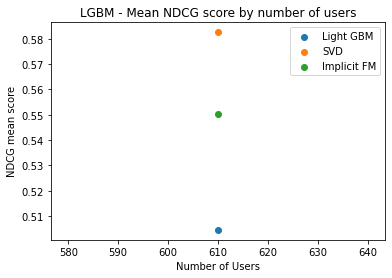

In [146]:
plt.scatter(len(num_users),lgbm_mean,label = 'Light GBM')
plt.scatter(len(num_users),svd_mean, label = 'SVD')
plt.scatter(len(num_users),ifm_mean, label = 'Implicit FM')
plt.xlabel('Number of Users')
plt.ylabel('NDCG mean score')
plt.title('LGBM - Mean NDCG score by number of users')
plt.legend()

In [147]:
a = excel_df.columns.values
a[1:47]

array(['model1_score', 'model2_score', 'train_label', 'test_label',
       'y_val', 'LGBM Score'], dtype=object)

## Feature Importance

In [148]:
feature_names = excel_df.columns.values[1:47]
feature_names = ['ifm', 'svd']

Text(0.5, 1.0, 'Importance of Features')

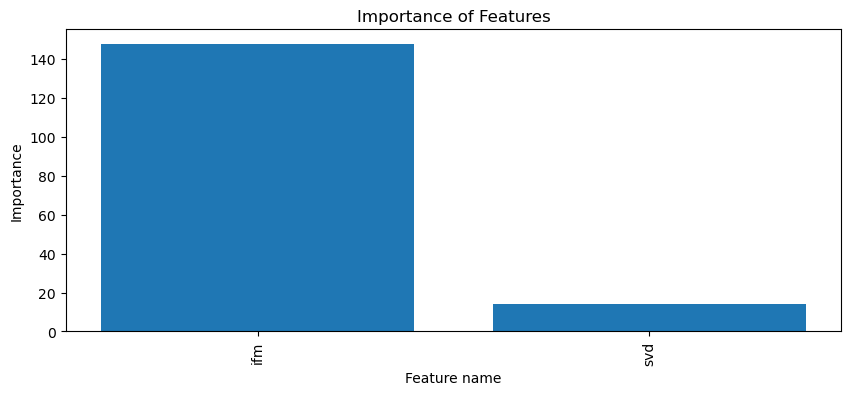

In [149]:
from matplotlib.pyplot import figure
figure(figsize=(10, 4),dpi=100)
plt.bar(feature_names,gbm.feature_importances_)
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Feature name')
plt.title('Importance of Features')

In [150]:
gbm.feature_importances_

array([147.6512177 ,  14.32481003])

## Save comparison

In [151]:
#ndcg_df.to_pickle("./ndcg_f1-15_minus67_100k_negative_rank.pkl")

# Research Questions

## What is the impact of genre features one the effectiveness of a model for movie recommendations?

1. Post-hoc analysis
2. Spearman correlation
try different features, see what happens, and analyze it to explain. 
3. Which genre matter the most (biggest impact on performance)

### No genre features

In [152]:
no_genre_features = np.stack((feature1,feature2,feature3,feature5,
                     feature7[0], feature7[1],feature7[2], feature7[3],
                     feature7[4], feature7[5],feature7[6], feature7[7],
                     feature7[8], feature7[9],feature7[10], feature7[11],
                     feature7[12], feature7[13],feature7[14], feature7[15],
                     feature7[16], feature7[17],feature7[18], feature7[19],
                     feature7[20], feature7[21],feature7[22], feature7[23],
                     feature7[24], feature7[25],feature7[26], feature7[27],
                     feature7[28], feature7[29],feature7[30], feature7[31],feature47))

In [153]:
X_no_genre = np.array(no_genre_features)
X_no_genre = X_no_genre.reshape(len(num_users)*k, len(no_genre_features))
X_train_no_genre = X_no_genre
X_test_no_genre = X_no_genre
X_val_no_genre = X_no_genre

In [154]:
gbm1 = lgb.LGBMRanker(min_child_samples=1, learning_rate=.1, n_jobs=2, importance_type='gain',
                     num_leaves=31, min_child_weight=100)
gbm1.fit(X_train_no_genre, y_train, group=group_train,
        eval_set=[(X_val_no_genre, y_val)], eval_group=[group_val],
        eval_at=[1, 3, 5, 10], eval_metric='ndcg')

[1]	valid_0's ndcg@1: 0.0278689	valid_0's ndcg@3: 0.0817279	valid_0's ndcg@5: 0.0820389	valid_0's ndcg@10: 0.0963962
[2]	valid_0's ndcg@1: 0.0360656	valid_0's ndcg@3: 0.0675883	valid_0's ndcg@5: 0.0743007	valid_0's ndcg@10: 0.0810475
[3]	valid_0's ndcg@1: 0.0344262	valid_0's ndcg@3: 0.0588879	valid_0's ndcg@5: 0.0676168	valid_0's ndcg@10: 0.0797227
[4]	valid_0's ndcg@1: 0.0311475	valid_0's ndcg@3: 0.0603623	valid_0's ndcg@5: 0.0664259	valid_0's ndcg@10: 0.0742543
[5]	valid_0's ndcg@1: 0.0278689	valid_0's ndcg@3: 0.0563326	valid_0's ndcg@5: 0.0623295	valid_0's ndcg@10: 0.0732614
[6]	valid_0's ndcg@1: 0.0327869	valid_0's ndcg@3: 0.0566807	valid_0's ndcg@5: 0.0626731	valid_0's ndcg@10: 0.0713456
[7]	valid_0's ndcg@1: 0.0245902	valid_0's ndcg@3: 0.0558611	valid_0's ndcg@5: 0.0613667	valid_0's ndcg@10: 0.0716159
[8]	valid_0's ndcg@1: 0.0245902	valid_0's ndcg@3: 0.0534203	valid_0's ndcg@5: 0.0548745	valid_0's ndcg@10: 0.0672337
[9]	valid_0's ndcg@1: 0.0213115	valid_0's ndcg@3: 0.0518817	vali

[72]	valid_0's ndcg@1: 0.0147541	valid_0's ndcg@3: 0.0407727	valid_0's ndcg@5: 0.0520848	valid_0's ndcg@10: 0.0634871
[73]	valid_0's ndcg@1: 0.0163934	valid_0's ndcg@3: 0.0407727	valid_0's ndcg@5: 0.0511068	valid_0's ndcg@10: 0.0626532
[74]	valid_0's ndcg@1: 0.0163934	valid_0's ndcg@3: 0.041542	valid_0's ndcg@5: 0.0522837	valid_0's ndcg@10: 0.0627603
[75]	valid_0's ndcg@1: 0.0163934	valid_0's ndcg@3: 0.0410566	valid_0's ndcg@5: 0.0509643	valid_0's ndcg@10: 0.0619363
[76]	valid_0's ndcg@1: 0.0180328	valid_0's ndcg@3: 0.0413405	valid_0's ndcg@5: 0.0507787	valid_0's ndcg@10: 0.0627848
[77]	valid_0's ndcg@1: 0.0180328	valid_0's ndcg@3: 0.0421098	valid_0's ndcg@5: 0.0519068	valid_0's ndcg@10: 0.0637984
[78]	valid_0's ndcg@1: 0.0180328	valid_0's ndcg@3: 0.0423113	valid_0's ndcg@5: 0.0521457	valid_0's ndcg@10: 0.0636224
[79]	valid_0's ndcg@1: 0.0163934	valid_0's ndcg@3: 0.0421098	valid_0's ndcg@5: 0.052928	valid_0's ndcg@10: 0.063132
[80]	valid_0's ndcg@1: 0.0163934	valid_0's ndcg@3: 0.042027

LGBMRanker(importance_type='gain', min_child_samples=1, min_child_weight=100,
           n_jobs=2)

Text(0.5, 1.0, 'Importance of Features')

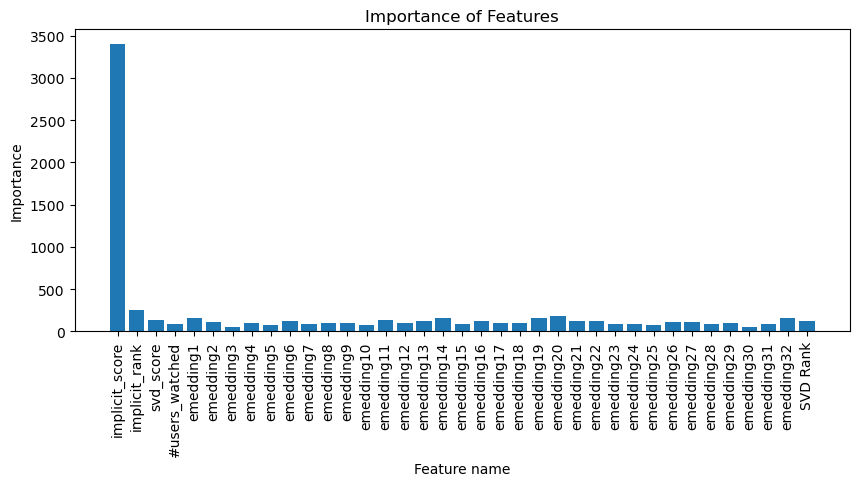

In [155]:
feature_names_no_genre = ('implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
                 'emedding1', 'emedding2', 'emedding3',
                 'emedding4', 'emedding5', 'emedding6',
                 'emedding7', 'emedding8', 'emedding9',
                 'emedding10', 'emedding11', 'emedding12',
                 'emedding13', 'emedding14', 'emedding15',
                 'emedding16', 'emedding17', 'emedding18',
                 'emedding19', 'emedding20', 'emedding21',
                 'emedding22', 'emedding23', 'emedding24',
                 'emedding25', 'emedding26', 'emedding27',
                 'emedding28', 'emedding29', 'emedding30',
                 'emedding31', 'emedding32', 'SVD Rank')
figure(figsize = (10, 4), dpi = 100)
plt.bar(feature_names_no_genre, gbm1.feature_importances_)
plt.xticks(rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Feature name')
plt.title('Importance of Features')

In [156]:
gbm1.feature_importances_

array([3404.01452935,  257.74028742,  131.50999117,   93.41462922,
        160.83828312,  110.56928211,   52.24227536,   97.79822981,
         81.09534717,  129.24540651,   93.16325301,   99.76372945,
        101.84219724,   79.7821216 ,  134.99887735,   97.80555099,
        121.31160587,  155.08243185,   93.97104108,  121.56874973,
        102.87830476,  103.29091978,  156.21655279,  181.56745362,
        121.38202429,  118.82486528,   91.20501965,   91.04583704,
         74.12661976,  113.16160488,  110.66874081,   86.00393939,
         96.62106878,   56.87423772,   89.99711293,  159.97711645,
        121.87634683])

In [157]:
st.spearmanr(np.array(feature1).reshape(len(num_users)*k,), np.array(feature3).reshape(len(num_users)*k,))

SpearmanrResult(correlation=0.3740818868527498, pvalue=0.0)

In [158]:
st.spearmanr(np.array(feature9).reshape(len(num_users)*k,), gbm1.predict(X_test_no_genre).reshape(len(num_users)*k,))

SpearmanrResult(correlation=0.0027656297137522256, pvalue=0.40283735743935234)

In [159]:
pred_no_genre = gbm1.predict(X_test_no_genre)
len(pred_no_genre)

91500

## What is the impact of items' embeddings features on the effectiveness of a model for item recommendations?

1. Post-hoc analysis
2. Spearman correlation
try different features, see what happens, and analyze it to explain. 


### No item embeddings features

In [160]:
no_embeddings_features = np.stack((feature1,feature2,feature3,feature4,feature5,feature8,
                              feature9,feature10,feature11,feature12,feature13,
                              feature14,feature15,feature47))

In [161]:
X_no_emb = np.array(no_embeddings_features)
X_no_emb = X_no_emb.reshape(len(num_users)*k, len(no_embeddings_features))
X_train_no_emb = X_no_emb
X_test_no_emb = X_no_emb
X_val_no_emb = X_no_emb

In [162]:
gbm2 = lgb.LGBMRanker(min_child_samples=1, learning_rate=.1, n_jobs=2, importance_type='gain',
                     num_leaves=31, min_child_weight=100)
gbm2.fit(X_train_no_emb, y_train, group=group_train,
        eval_set=[(X_val_no_emb, y_val)], eval_group=[group_val],
        eval_at=[1, 3, 5, 10], early_stopping_rounds = 50, eval_metric='ndcg')

[1]	valid_0's ndcg@1: 0.0885246	valid_0's ndcg@3: 0.123445	valid_0's ndcg@5: 0.117752	valid_0's ndcg@10: 0.11493
Training until validation scores don't improve for 50 rounds
[2]	valid_0's ndcg@1: 0.0737705	valid_0's ndcg@3: 0.0903356	valid_0's ndcg@5: 0.0942139	valid_0's ndcg@10: 0.0944423
[3]	valid_0's ndcg@1: 0.0688525	valid_0's ndcg@3: 0.0850511	valid_0's ndcg@5: 0.0861484	valid_0's ndcg@10: 0.085771
[4]	valid_0's ndcg@1: 0.0868852	valid_0's ndcg@3: 0.0875078	valid_0's ndcg@5: 0.0864967	valid_0's ndcg@10: 0.0895519
[5]	valid_0's ndcg@1: 0.0836066	valid_0's ndcg@3: 0.0817015	valid_0's ndcg@5: 0.0845197	valid_0's ndcg@10: 0.0874767
[6]	valid_0's ndcg@1: 0.0836066	valid_0's ndcg@3: 0.0849802	valid_0's ndcg@5: 0.0847871	valid_0's ndcg@10: 0.0877985
[7]	valid_0's ndcg@1: 0.0737705	valid_0's ndcg@3: 0.0847145	valid_0's ndcg@5: 0.0844231	valid_0's ndcg@10: 0.0878392
[8]	valid_0's ndcg@1: 0.0770492	valid_0's ndcg@3: 0.0861524	valid_0's ndcg@5: 0.0837374	valid_0's ndcg@10: 0.0890992
[9]	vali

LGBMRanker(importance_type='gain', min_child_samples=1, min_child_weight=100,
           n_jobs=2)

In [163]:
len(gbm2.feature_importances_)

14

Text(0.5, 1.0, 'Importance of Features')

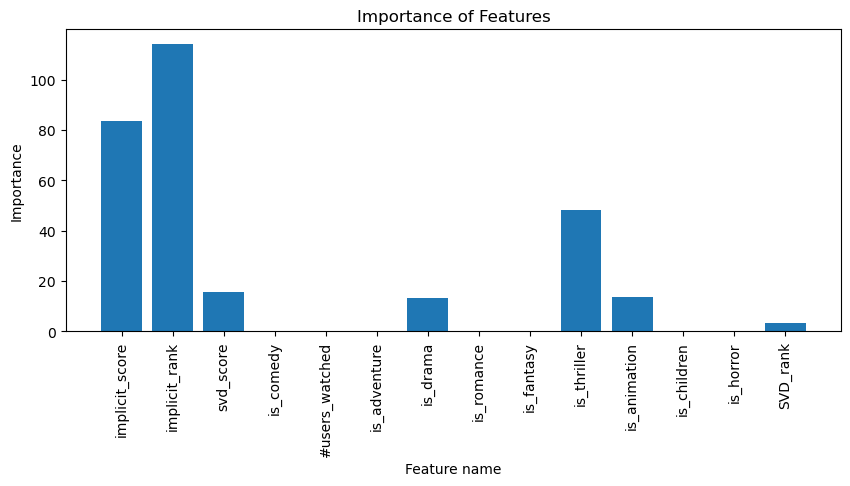

In [164]:
feature_names_no_emb = ('implicit_score', 'implicit_rank', 'svd_score', 'is_comedy', '#users_watched',
                        'is_adventure', 'is_drama', 'is_romance', 'is_fantasy', 'is_thriller',
                        'is_animation', 'is_children', 'is_horror', 'SVD_rank')

figure(figsize=(10, 4), dpi=100)
plt.bar(feature_names_no_emb, gbm2.feature_importances_)
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Feature name')
plt.title('Importance of Features')

In [165]:
gbm2.feature_importances_

array([ 83.50340271, 114.27200317,  15.55309963,   0.        ,
         0.        ,   0.        ,  13.45069981,   0.        ,
         0.        ,  48.21521044,  13.56639957,   0.        ,
         0.        ,   3.17130995])

In [166]:
st.spearmanr(np.array(feature9).reshape(len(num_users)*k,), gbm2.predict(X_test_no_emb).reshape(len(num_users)*k,))

SpearmanrResult(correlation=-0.006459348354761087, pvalue=0.05071542979316777)

In [167]:
st.spearmanr(np.array(feature1).reshape(len(num_users)*k,), np.array(feature14).reshape(len(num_users)*k,))

SpearmanrResult(correlation=0.028227891173856677, pvalue=1.3395440863505104e-17)

In [168]:
pred_no_emb = gbm2.predict(X_test_no_emb)

## What is the impact of the items’rank on the effectivenessof amodelfor item recommendations?

1. Post-hoc analysis
2. Spearman correlation
try different features, see what happens, and analyze it to explain. 


### No models' rank features

In [169]:
no_rank_features = np.stack((feature1, feature3, feature4, feature5, feature7[0],
                             feature7[1], feature7[2], feature7[3],
                             feature7[4], feature7[5], feature7[6], feature7[7],
                             feature7[8], feature7[9], feature7[10], feature7[11],
                             feature7[12], feature7[13], feature7[14], feature7[15],
                             feature7[16], feature7[17], feature7[18], feature7[19],
                             feature7[20], feature7[21], feature7[22], feature7[23],
                             feature7[24], feature7[25], feature7[26], feature7[27],
                             feature7[28], feature7[29], feature7[30], feature7[31],
                             feature8, feature9, feature10, feature11, feature12, feature13,
                             feature14, feature15))

In [170]:
X_no_rank = np.array(no_rank_features)
X_no_rank = X_no_rank.reshape(len(num_users)*k, len(no_rank_features))
X_train_no_rank = X_no_rank
X_test_no_rank = X_no_rank
X_val_no_rank = X_no_rank

In [171]:
gbm3 = lgb.LGBMRanker(min_child_samples=1, learning_rate=.1, n_jobs=2, importance_type='gain',
                     num_leaves=31, min_child_weight=100)
gbm3.fit(X_train_no_rank, y_train, group=group_train,
        eval_set=[(X_val_no_rank, y_val)], eval_group=[group_val],
        eval_at=[1, 3, 5, 10],eval_metric='ndcg')

[1]	valid_0's ndcg@1: 0.0311475	valid_0's ndcg@3: 0.0624688	valid_0's ndcg@5: 0.0752574	valid_0's ndcg@10: 0.0871847
[2]	valid_0's ndcg@1: 0.0245902	valid_0's ndcg@3: 0.05571	valid_0's ndcg@5: 0.0663641	valid_0's ndcg@10: 0.0744533
[3]	valid_0's ndcg@1: 0.0262295	valid_0's ndcg@3: 0.0561771	valid_0's ndcg@5: 0.0598983	valid_0's ndcg@10: 0.0728587
[4]	valid_0's ndcg@1: 0.0278689	valid_0's ndcg@3: 0.0523948	valid_0's ndcg@5: 0.0581186	valid_0's ndcg@10: 0.0731884
[5]	valid_0's ndcg@1: 0.0344262	valid_0's ndcg@3: 0.0516255	valid_0's ndcg@5: 0.0573531	valid_0's ndcg@10: 0.071656
[6]	valid_0's ndcg@1: 0.0311475	valid_0's ndcg@3: 0.0495008	valid_0's ndcg@5: 0.0574475	valid_0's ndcg@10: 0.0708278
[7]	valid_0's ndcg@1: 0.0311475	valid_0's ndcg@3: 0.0494825	valid_0's ndcg@5: 0.0561195	valid_0's ndcg@10: 0.0701686
[8]	valid_0's ndcg@1: 0.0295082	valid_0's ndcg@3: 0.0446834	valid_0's ndcg@5: 0.0520789	valid_0's ndcg@10: 0.0680422
[9]	valid_0's ndcg@1: 0.0295082	valid_0's ndcg@3: 0.0441981	valid_0

[72]	valid_0's ndcg@1: 0.0295082	valid_0's ndcg@3: 0.0432091	valid_0's ndcg@5: 0.0498311	valid_0's ndcg@10: 0.0604774
[73]	valid_0's ndcg@1: 0.0311475	valid_0's ndcg@3: 0.0427237	valid_0's ndcg@5: 0.0507952	valid_0's ndcg@10: 0.0601197
[74]	valid_0's ndcg@1: 0.0311475	valid_0's ndcg@3: 0.042623	valid_0's ndcg@5: 0.0512013	valid_0's ndcg@10: 0.0606278
[75]	valid_0's ndcg@1: 0.0311475	valid_0's ndcg@3: 0.0430076	valid_0's ndcg@5: 0.0502089	valid_0's ndcg@10: 0.0599322
[76]	valid_0's ndcg@1: 0.0311475	valid_0's ndcg@3: 0.0425222	valid_0's ndcg@5: 0.0505521	valid_0's ndcg@10: 0.0594544
[77]	valid_0's ndcg@1: 0.0327869	valid_0's ndcg@3: 0.0431908	valid_0's ndcg@5: 0.0497935	valid_0's ndcg@10: 0.0591908
[78]	valid_0's ndcg@1: 0.0327869	valid_0's ndcg@3: 0.0424215	valid_0's ndcg@5: 0.0498341	valid_0's ndcg@10: 0.0591963
[79]	valid_0's ndcg@1: 0.0327869	valid_0's ndcg@3: 0.0429069	valid_0's ndcg@5: 0.0501605	valid_0's ndcg@10: 0.0591768
[80]	valid_0's ndcg@1: 0.0360656	valid_0's ndcg@3: 0.0439

LGBMRanker(importance_type='gain', min_child_samples=1, min_child_weight=100,
           n_jobs=2)

In [172]:
#len(feature_names_no_rank)#

Text(0.5, 1.0, 'Importance of Features')

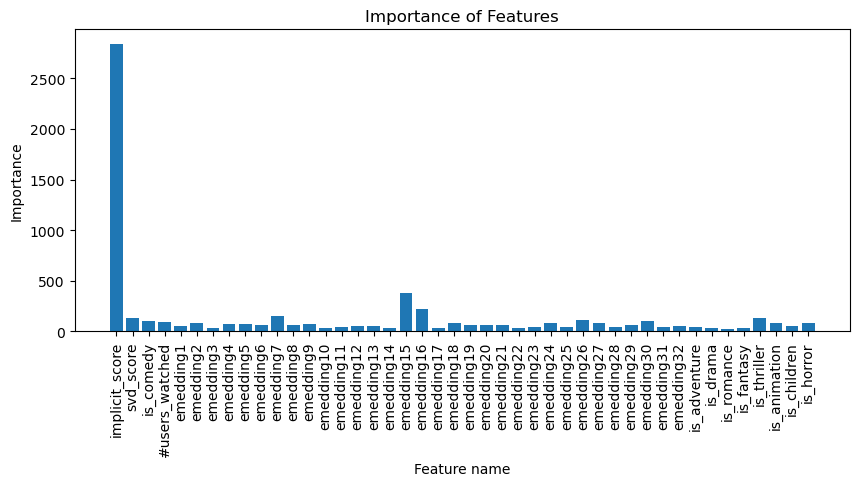

In [173]:
feature_names_no_rank = ('implicit_score', 'svd_score', 'is_comedy', '#users_watched',
                        'emedding1', 'emedding2', 'emedding3',
                        'emedding4', 'emedding5', 'emedding6',
                        'emedding7', 'emedding8', 'emedding9',
                        'emedding10', 'emedding11', 'emedding12',
                        'emedding13', 'emedding14', 'emedding15',
                        'emedding16', 'emedding17', 'emedding18',
                        'emedding19', 'emedding20', 'emedding21',
                        'emedding22', 'emedding23', 'emedding24',
                        'emedding25', 'emedding26', 'emedding27',
                        'emedding28', 'emedding29', 'emedding30',
                        'emedding31', 'emedding32',
                        'is_adventure', 'is_drama', 'is_romance', 'is_fantasy', 'is_thriller',
                        'is_animation', 'is_children', 'is_horror')

figure(figsize=(10, 4), dpi=100)
plt.bar(feature_names_no_rank, gbm3.feature_importances_)
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Feature name')
plt.title('Importance of Features')

In [174]:
gbm3.feature_importances_

array([2842.39393256,  131.56816831,  103.27472371,   97.67209643,
         55.27465868,   80.85358691,   39.00458831,   69.04575837,
         78.05491132,   60.65203112,  155.92228776,   66.5403139 ,
         72.5583545 ,   36.09971738,   40.84274432,   53.83344021,
         58.97413859,   33.82782608,  381.06002361,  222.42826259,
         39.21117598,   83.12411034,   59.18686807,   67.58745992,
         68.32863718,   37.29111284,   40.03677885,   81.54149723,
         42.21520099,  117.00836605,   87.1748302 ,   42.38363433,
         62.56844288,  106.49760872,   45.55899769,   52.90326637,
         42.67408314,   31.58000994,   28.33492023,   36.01396704,
        129.14313658,   81.352843  ,   55.2045657 ,   81.55802846])

In [175]:
st.spearmanr(np.array(feature9).reshape(len(num_users)*k,), gbm3.predict(X_test_no_rank).reshape(len(num_users)*k,))

SpearmanrResult(correlation=-0.0037465330364687068, pvalue=0.2570983529776087)

In [176]:
st.spearmanr(np.array(feature1).reshape(len(num_users)*k,), np.array(feature14).reshape(len(num_users)*k,))

SpearmanrResult(correlation=0.028227891173856677, pvalue=1.3395440863505104e-17)

In [177]:
pred_no_rank = gbm3.predict(X_test_no_rank)

# Draft

## Excel-Like

In [178]:
excel1_df = pd.DataFrame({'movie_id': target_movies[0],'rank':feature2[0],'model1_score':feature1[0], 'model2_score':feature3[0],'is_comedy':feature4[0],
                            '#users_watched':feature5[0], 'train_label':label_train[0], 'test_label':label_test[0],
                            'label_val':label_val[0],'LGBM Score':lgbm_pred_per_user[0]})

In [179]:
excel1_df

,movie_id,rank,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
0,1,16.0,12.930397,1.687722,1,215,1,0,0,0.048622
1,6,43.0,12.080826,0.945642,0,102,0,0,1,0.048622
2,47,17.0,12.920485,0.741415,0,203,0,0,0,0.048622
3,50,6.0,13.635176,0.871874,0,204,1,0,0,0.048622
4,110,1.0,14.060660,1.408157,0,237,0,1,0,0.026137
...,...,...,...,...,...,...,...,...,...,...
145,2387,145.0,2.797690,0.226162,1,16,0,0,0,-0.053789
146,1920,143.0,3.864496,0.433098,0,18,0,0,0,0.002981
147,2005,132.5,7.526427,0.559695,1,57,0,0,0,-0.053789
148,1617,84.5,11.234195,1.075539,0,97,0,0,0,-0.053789


In [180]:
excel1_df = excel1_df.sort_values('LGBM Score',ascending = False)
excel1_df.head(10)

,movie_id,rank,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
0,1,16.0,12.930397,1.687722,1,215,1,0,0,0.048622
33,1214,73.0,11.361501,1.223359,0,146,0,1,0,0.048622
24,648,80.0,11.336709,1.185335,0,162,0,0,0,0.048622
25,733,69.5,11.412301,0.894807,0,121,0,0,0,0.048622
27,780,67.5,11.443278,1.348182,0,202,0,0,0,0.048622
28,1073,65.0,11.477365,1.267667,1,119,0,0,0,0.048622
29,1196,66.0,11.455667,1.362848,0,211,0,1,0,0.048622
30,1198,57.0,11.649925,1.273329,0,200,0,0,1,0.048622
31,1210,55.0,11.713925,1.265358,0,196,0,0,0,0.048622
32,1213,99.0,10.982478,1.116733,0,126,1,0,0,0.048622


In [181]:
relevance_lgbm_firstUser = excel1_df['test_label'].values.tolist()

In [182]:
L1GBM_ndcg = NDCG_forUser(relevance_lgbm_firstUser)
L1GBM_ndcg

0.5477691229553578

In [183]:
from sklearn.metrics import dcg_score
true = np.asarray([actual])
pred = np.asarray([predicted_rank_svd])
dcg = dcg_score(true,pred)
idcg = dcg_score(true,true)
ndcg = dcg/idcg

NameError: name 'predicted_rank_svd' is not defined

In [ ]:
ndcg

In [ ]:
from sklearn.metrics import ndcg_score
n = ndcg_score(true,pred)
n

In [ ]:
'''relevance = []
for i in range(20,40):
    if predicted_rank_svd[i] in actual:
        relevance.append(1)
    else:
        relevance.append(0)'''

In [ ]:
svd_rank_allUsers = []
for i in range(1,len(num_users)+1):
    already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
    svd_rank_allUsers.append(predictions['movieId'].index.tolist()) 


In [ ]:
'''def NDCG_forUser_SVD(user):
    return dcg(svd_predictions[svd_predictions_df.index == user]) / ideal_dcg(svd_predictions[svd_predictions_df.index == user])'''

In [ ]:
'''NDCG_SVD = NDCG_forUser_SVD(2)'''

In [ ]:
'''NDCG_SVD'''

Take as features the predicted ratings for the users of SVD and Implicit for the next step?

## KNN

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [ ]:
df_movie_features = ratings_df.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [ ]:
df_movie_features

In [ ]:
height = [len(df_movie_features.values[df_movie_features.values== 0]),len(df_movie_features.values[df_movie_features.values==0.5]),
          len(df_movie_features.values[df_movie_features.values== 1]),len(df_movie_features.values[df_movie_features.values==1.5]),
          len(df_movie_features.values[df_movie_features.values== 2]),len(df_movie_features.values[df_movie_features.values==2.5]),
          len(df_movie_features.values[df_movie_features.values== 3]),len(df_movie_features.values[df_movie_features.values==3.5]),
          len(df_movie_features.values[df_movie_features.values== 4]),len(df_movie_features.values[df_movie_features.values==4.5]),
          len(df_movie_features.values[df_movie_features.values== 5])]
x = ('0','0.5', '1','1.5' ,'2','2.5', '3','3.5', '4','4.5','5')
plt.bar(x, height)
plt.xlabel('Rating')
plt.ylabel('Number of users')
plt.show()


A lot of ratings in the user-movie matrix are zero, so the data are extremely sparse.

To makes sesne the idea of obtaining the taste of the users, they should have rated at least 20 movies. Otherwise, the taste of them is not clear. The users that have rated less than 20 movies will be excluded. Also the movies that have less than 20 ratings will be excluded too.

In [ ]:
popularity_thres = 20
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)
# filter data to come to an approximation of user likings.
ratings_thres = 20
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(ratings_df)

In [ ]:
ratings_df[24400:24450]

In [ ]:
excel_df

## Implicit Sequence model

In [ ]:
from spotlight.sequence.implicit import ImplicitSequenceModel
from spotlight.evaluation import sequence_mrr_score
from spotlight.sequence.implicit import ImplicitSequenceModel

### Train Implicit Sequence model

In [ ]:
'''sequence_model  = ImplicitSequenceModel(n_iter = 5)

current = time.time()
sequence_model.fit(interactions = implicit_train.to_sequence(),verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))'''

In [ ]:
#sequence_model.predict(sequences = 9724)

### MRR Score

In [ ]:
#print(sequence_mrr_score(sequence_model, implicit_test.to_sequence()).mean())

### Top-K predictions for a user

In [ ]:
#allUsers_topK_sequence = allUsers_topK_implicit(sequence_model)

### NDCG Score

In [ ]:
#relevance_sequence_full = relevance_spotlight_implicit(allUsers_topK_sequence)

In [ ]:
#allUsers_sequence_ndcg = allUsers_ndcg(relevance_sequence_full)

In [ ]:
#allUsers_sequence_ndcg = pd.Series(allUsers_sequence_ndcg).fillna(0).tolist()

### MAP

In [ ]:
'''ran = [1,0,1,1,0]
ran = r2
count_positive = 0
positives = []
ap_perUser = []
count = 0
for r in ran:
    #for i in range(len(relevance[0])):
    count += 1
    if r == 1:
        count_positive += 1
        positives.append(count_positive/count)
ap_perUser.append(np.array(positives).sum()/count_positive)
count_positive = 0
positives = []'''

In [ ]:
#ap_perUser

In [ ]:
r_f = []
r_f.append([1,0,1,1,0])
r_f.append([0,0,0,1,1])

In [ ]:
r_f

In [ ]:
rap = calculate_averagePrecision(r_f)

In [ ]:
rap

In [ ]:
rmap = calculate_MAP(rap)
rmap

### MRR

In [ ]:
len(af)

In [ ]:
afrr = RR_forUsers(af)
mrr_af = calculate_mrr(afrr)

In [ ]:
mrr_af

### Built-in MRR score

In [ ]:
from spotlight.evaluation import mrr_score
print(mrr_score(implicit_model, implicit_test, train=implicit_train, k=100).mean())

### Second NDCG Score

Code used from https://github.com/nikitaa30/Recommender-Systems/blob/master/matrix_factorisation_svd.py

Provide top-K predictions for a user

In [ ]:
'''def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',
               right_on = 'movie_id').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations'''

In [ ]:
'''already_rated, predictions = recommend_movies(svd_predictions_score_df, 1, movies_df, ratings_df, 100)
predictions.head()'''

The function SVD_topK_allUsers returens a list that contains the top-K recommendations for each user.

In [ ]:
'''def SVD_topK_allUsers():
    allUsers_already_rated = []
    allUsers_predictions = []
    for i in range(1,len(num_users)+1):
        already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
        allUsers_already_rated.append(already_rated)
        allUsers_predictions.append(predictions)
    return allUsers_predictions'''

#### NDCG Score

The function SVD_relevance returns a list that contains the relevance (0s and 1s) between the top-K recommendations and the movies that each user actually watched.

In [ ]:
'''def SVD_relevance():
    svd_topK = SVD_topK_allUsers()
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count]['movieId'].values[j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full'''

In [ ]:
#svd_relevance = SVD_relevance()

In [ ]:
#allUsers_svd_ndcg = allUsers_ndcg(svd_relevance)